In [4]:
import wfdb
import os
import pandas as pd
import wfdb.processing as wp
import numpy as np
import pickle
from biosppy.signals import ecg, tools

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn, optim

import pytorch_model_summary

from sklearn.preprocessing import MinMaxScaler as mms

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.patheffects import withStroke

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIbLE_DEVICES"] = "0"

In [5]:
# Data Extract From Physionet *.dat

input_path = "./ECG_DATASET/mitbih_stch/"
records = open(input_path+"RECORDS","r")
records_list = []
for l in records:
    l = l.rstrip()
#     if l in ["00735","03665"]:
#         continue
    records_list.append(l)
records.close()
print(records_list)

['300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327']


In [91]:
#record = wfdb.rdsamp("./ECG_DATASET/mitbih_atrial/files/00735", sampfrom=0, sampto=650000)
#annotation =wfdb.rdann("./ECG_DATASET/mitbih_atrial/files/00735","atr", sampfrom=0, sampto=650000)
idx = 16
record = wfdb.rdrecord("./ECG_DATASET/mitbih_stch/"+records_list[idx])
annotation =wfdb.rdann("./ECG_DATASET/mitbih_stch/"+records_list[idx],"atr")

In [92]:
record.__dict__

{'record_name': '316',
 'n_sig': 1,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 555012,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG'],
 'p_signal': array([[-0.53 ],
        [-0.54 ],
        [-0.54 ],
        ...,
        [-0.155],
        [-0.155],
        [-0.17 ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['316.dat'],
 'fmt': ['212'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [200.0],
 'baseline': [0],
 'units': ['mV'],
 'adc_res': [12],
 'adc_zero': [0],
 'init_value': [-106],
 'checksum': [-17654],
 'block_size': [0]}

In [93]:
annotation.__dict__

{'record_name': '316',
 'extension': 'atr',
 'sample': array([   165,    369,    583, ..., 554480, 554693, 554904]),
 'symbol': ['N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'

%matplotlib notebook
wfdb.plot_wfdb(record=record, annotation = annotation,
         title='Record 310 from MIT-BIH ST change Database',
         time_units = 'seconds', figsize = (10, 7), ecg_grids = 'all')

In [94]:
def extract_from_sbj(idx, sampfrom, sampto):
    record_sig = wfdb.rdsamp(input_path+records_list[idx], channels=[0], sampfrom=sampfrom, sampto = sampto)
    record_ann = list(wfdb.rdann(input_path+records_list[idx],"atr",sampfrom=sampfrom, sampto = sampto).sample)[0:] # R Peak x_position
    record_ann_sym = list(wfdb.rdann(input_path+records_list[idx], "atr",sampfrom=sampfrom, sampto = sampto).symbol)[0:] # R Peak Symbol
    interval = wp.ann2rr(input_path+records_list[idx], 'atr', as_array=True)

    return record_sig, record_ann, record_ann_sym

In [97]:
# idx = 
sampfrom = 0
sampto = record.__dict__["sig_len"]
record_sig, record_ann, record_ann_sym = extract_from_sbj(idx,sampfrom,sampto)
print(record_sig)
# print(record_ann)
print(record_ann_sym)

(array([[-0.53 ],
       [-0.54 ],
       [-0.54 ],
       ...,
       [-0.155],
       [-0.155],
       [-0.17 ]]), {'fs': 360, 'sig_len': 555012, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['ECG'], 'comments': []})
['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

<IPython.core.display.Javascript object>


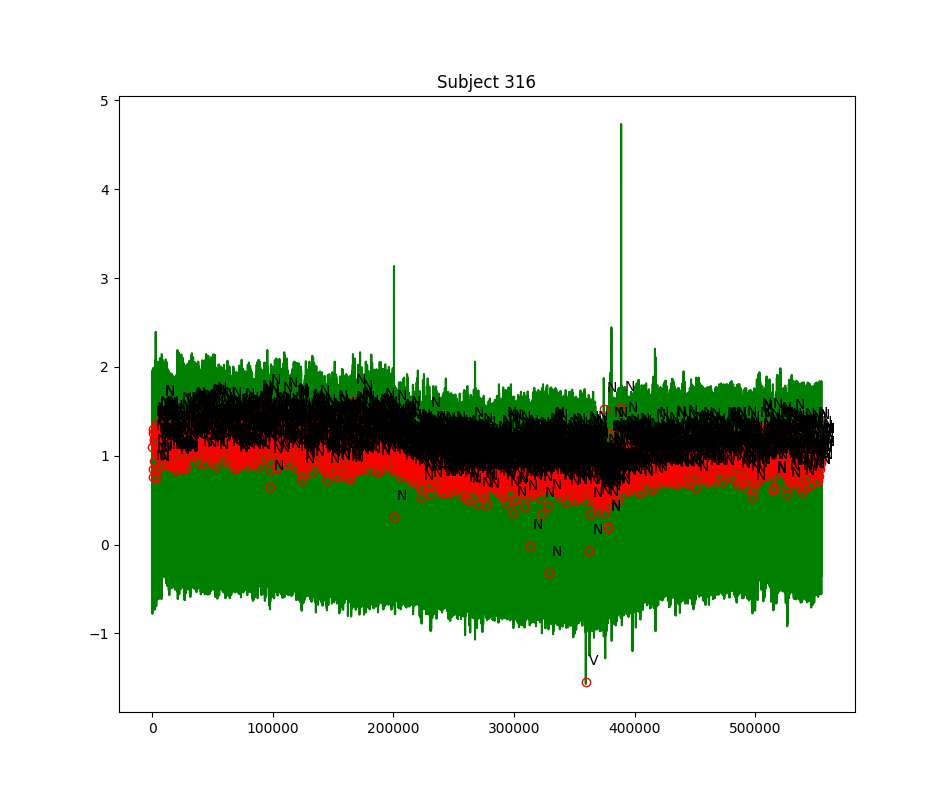

In [98]:
%matplotlib notebook
fig = plt.figure(figsize=(9.5,8))
ax_ann = fig.add_subplot(1,1,1)
ax_ann.set_title("Subject {}".format(records_list[idx]))
x_data = np.squeeze(np.array(record_sig[0]),axis=1)
ax_ann.plot(x_data,color="green")

for i,x_location in enumerate(record_ann):
    if record_ann_sym[i] == 5:
        continue
    ax_ann.annotate(record_ann_sym[i], xy=(x_location,x_data[x_location-sampfrom]),
                    xycoords="data", textcoords="offset pixels", xytext=(3,17))

record_ann_x = [x_location-sampfrom for i,x_location in enumerate(record_ann) if record_ann_sym[i]!=5]
record_ann_v = [x_data[x_location-sampfrom] for x_location in record_ann_x]
ax_ann.plot(record_ann_x, record_ann_v, "ro", linewidth=2, fillstyle="none")

fig.show()

